In [1]:
import torch
import torchaudio
import librosa
import random
import os
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchaudio.functional as F
import torchaudio.transforms as T
import numpy as np
import pandas as pd
import scipy
from IPython.display import display, Audio
import hf00

In [3]:
'''
1. We will first have to create a table for the available datasets and what they offer
2. We then choose the best datasets to work with try to integrate them into the already written code
3. We add bg noise second wise, choose a simple AE architecture and exclusively train it for a few days.

'''
audio_sample = '../../LibriVox_Kaggle/achtgesichterambiwasse/achtgesichterambiwasse_0041.wav'

audio, label = hf00.get_random_audio_sec(audio_sample)

audio.shape, label.shape

(torch.Size([1, 16000]), torch.Size([1, 16000]))

In [11]:
class audioDataset(Dataset):

    def __init__(self, audio_df, audio_dir):
        #self.audio_df = pd.read_csv(audio_csvfile)
        self.audio_df = audio_df
        self.audio_dir = audio_dir

    def __len__(self):
        return len(self.audio_df)
    
    def __getitem__(self, index):
        audio_path = os.path.join(self.audio_dir, self.audio_df.iloc[index, 0])

        audio, label = hf00.get_random_audio_sec(audio_path)

        return audio, label

In [24]:
aud_dir = '../../LibriVox_Kaggle/'
train_df = pd.read_csv('only_audioFname_train.csv')
test_df = pd.read_csv('only_audioFname_test.csv')

train_df = train_df[2000:4000]
test_df = test_df[500:1000]

train_dataset = audioDataset(train_df,audio_dir=aud_dir)
test_dataset = audioDataset(test_df,audio_dir=aud_dir)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [21]:
torch.manual_seed(13)
torch.cuda.manual_seed(13)

class speechRemoval00(nn.Module):
    
    def __init__(self):
        super(speechRemoval00, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 32, kernel_size=3, padding=1),
            nn.ReLU()
            )
        
        self.decoder = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 1, kernel_size=3, padding=1),
            nn.ReLU()
            )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x


In [15]:
model = speechRemoval00()

model.load_state_dict(torch.load('model_conf00.pt'))

<All keys matched successfully>

In [25]:
torch.manual_seed(13)
torch.cuda.manual_seed(13)

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [26]:
epochs = 10

for epoch in range(0,epochs):

    for data in train_dataloader:
        
        model.train()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = loss_fn(outputs, inputs)

        # BP and optim
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch + 1}/{epochs}] Loss: {loss.item()}")


Epoch [1/10] Loss: 0.34160804748535156
Epoch [2/10] Loss: 0.06689592450857162
Epoch [3/10] Loss: 0.12005926668643951
Epoch [4/10] Loss: 0.060438547283411026
Epoch [5/10] Loss: 0.640385091304779
Epoch [6/10] Loss: 0.16879788041114807
Epoch [7/10] Loss: 0.09127315133810043
Epoch [8/10] Loss: 0.03615953400731087
Epoch [9/10] Loss: 0.06332489848136902
Epoch [10/10] Loss: 0.024414483457803726


In [36]:
sample = '../../LibriVox_Kaggle/achtgesichterambiwasse/achtgesichterambiwasse_0063.wav'
aud, ll = hf00.get_random_audio_sec(sample)

model = model.cpu()
model.eval()
with torch.inference_mode():
    pred = model(aud)

display(Audio(aud, rate=16000))
display(Audio(pred, rate=16000))


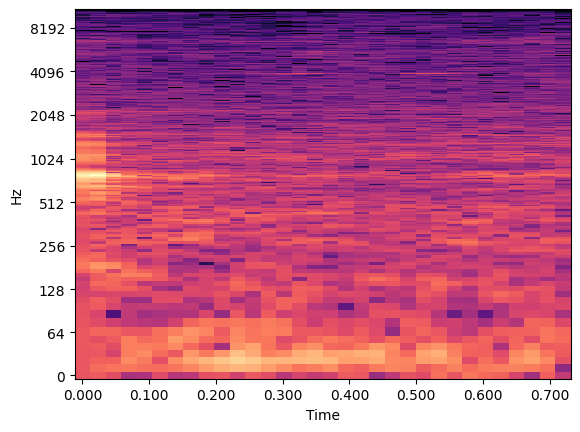

In [38]:
S_real, phase = librosa.magphase(librosa.stft(aud.squeeze().numpy()))
S_pred, phase = librosa.magphase(librosa.stft(pred.squeeze().numpy()))

librosa.display.specshow(librosa.amplitude_to_db(S_real, ref=np.max),
                         y_axis='log', x_axis='time')

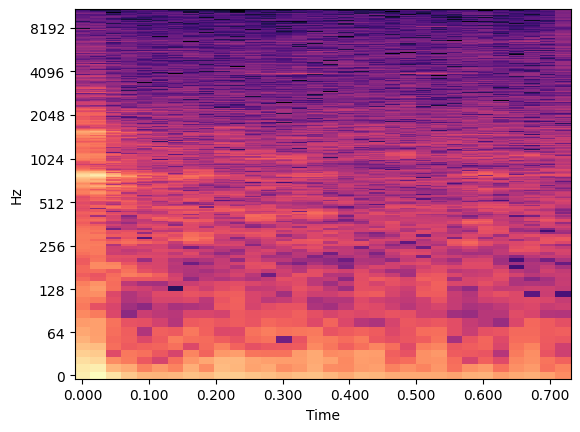

In [39]:
librosa.display.specshow(librosa.amplitude_to_db(S_pred, ref=np.max),
                         y_axis='log', x_axis='time')